In [1]:
import os
import re
import json

import numpy as np
import pandas as pd
from itertools import combinations

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

## Load data files

### Load origin game.csv

In [3]:
lol_df = pd.read_csv("data/lol_data.csv")
lol_df
# lol_df = lol_df.drop(["gameId", "creationTime","seasonId"], axis=1)

gameId   creationTime  gameDuration  seasonId  winner  firstBlood  \
0      3326086514  1504279457970          1949         9       1           2   
1      3229566029  1497848803862          1851         9       1           1   
2      3327363504  1504360103310          1493         9       1           2   
3      3326856598  1504348503996          1758         9       1           1   
4      3330080762  1504554410899          2094         9       1           2   
...           ...            ...           ...       ...     ...         ...   
51485  3308904636  1503076540231          1944         9       2           1   
51486  3215685759  1496957179355          3304         9       2           1   
51487  3322765040  1504029863961          2156         9       2           2   
51488  3256675373  1499562036246          1475         9       2           2   
51489  3317333020  1503612754059          1445         9       1           1   

       firstTower  firstInhibitor  firstBaron  firstDragon  ...  \
0               1               1           1            1  ...   
1               1               1           0            1  ...   
2               1               1           1            2  ...   
3               1               1           1            1  ...   
4               1               1           1            1  ...   
...           ...             ...         ...          ...  ...   
51485           2               2           0            2  ...   
51486           1               2           2            2  ...   
51487           2               2           0            1  ...   
51488           2               2           0            2  ...   
51489           1               1           1            2  ...   

       t2_towerKills  t2_inhibitorKills  t2_baronKills  t2_dragonKills  \
0                  5                  0              0               1   
1                  2                  0              0               0   
2                  2                  0              0               1   
3                  0                  0              0               0   
4                  3                  0              0               1   
...              ...                ...            ...             ...   
51485             10                  2              0               4   
51486             11                  7              4               4   
51487             10                  2              0               2   
51488             11                  3              0               1   
51489              1                  0              0               1   

       t2_riftHeraldKills  t2_ban1  t2_ban2  t2_ban3  t2_ban4  t2_ban5  
0                       1      114       67       43       16       51  
1                       0       11       67      238       51      420  
2                       0      157      238      121       57       28  
3                       0      164       18      141       40       51  
4                       0       86       11      201      122       18  
...                   ...      ...      ...      ...      ...      ...  
51485                   0       55       -1       90      238      157  
51486                   1      157       55      119      154      105  
51487                   0      113      122       53       11      157  
51488                   0      154       39       51       90      114  
51489                   0       11      157      141       31       18  

[51490 rows x 61 columns]

### Load champion files

In [4]:
champion_dict = pd.read_json('data/champion_info_2.json')
champ_info_df = pd.read_json((champion_dict['data']).to_json(), orient='index')
champ_info_df.set_index(['id'], inplace=True)
champ_info_df

tags                   title      key     name
id                                                                
266      [Fighter, Tank]        the Darkin Blade   Aatrox   Aatrox
103     [Mage, Assassin]     the Nine-Tailed Fox     Ahri     Ahri
84            [Assassin]      the Fist of Shadow    Akali    Akali
12       [Tank, Support]            the Minotaur  Alistar  Alistar
32          [Tank, Mage]           the Sad Mummy    Amumu    Amumu
..                   ...                     ...      ...      ...
154      [Tank, Fighter]       the Secret Weapon      Zac      Zac
238  [Assassin, Fighter]   the Master of Shadows      Zed      Zed
115               [Mage]  the Hexplosives Expert    Ziggs    Ziggs
26       [Support, Mage]        the Chronokeeper   Zilean   Zilean
143      [Mage, Support]      Rise of the Thorns     Zyra     Zyra

[139 rows x 4 columns]

### Load summoner spell files

In [5]:
spell_dict = pd.read_json('data/summoner_spell_info.json')
spell_info_df = pd.read_json((spell_dict['data']).to_json(), orient='index')
spell_info_df

id  summonerLevel                            name  \
1    1              6                         Cleanse   
11  11             10                           Smite   
12  12              6                        Teleport   
13  13              1                         Clarity   
14  14             10                          Ignite   
21  21              4                         Barrier   
3    3              4                         Exhaust   
30  30              1                    To the King!   
31  31              1                       Poro Toss   
32  32              1                            Mark   
33  33              1  Nexus Siege: Siege Weapon Slot   
34  34              1  Nexus Siege: Siege Weapon Slot   
35  35              1        Disabled Summoner Spells   
36  36              1        Disabled Summoner Spells   
4    4              8                           Flash   
6    6              1                           Ghost   
7    7              1                            Heal   

                             key  \
1                  SummonerBoost   
11                 SummonerSmite   
12              SummonerTeleport   
13                  SummonerMana   
14                   SummonerDot   
21               SummonerBarrier   
3                SummonerExhaust   
30            SummonerPoroRecall   
31             SummonerPoroThrow   
32              SummonerSnowball   
33     SummonerSiegeChampSelect1   
34     SummonerSiegeChampSelect2   
35  SummonerDarkStarChampSelect1   
36  SummonerDarkStarChampSelect2   
4                  SummonerFlash   
6                  SummonerHaste   
7                   SummonerHeal   

                                          description  
1   Removes all disables (excluding suppression an...  
11  Deals 390-1000 true damage (depending on champ...  
12  After channeling for 4.5 seconds, teleports yo...  
13  Restores 50% of your champion's maximum Mana. ...  
14  Ignites target enemy champion, dealing 70-410 ...  
21  Shields your champion from 115-455 damage (dep...  
3   Exhausts target enemy champion, reducing their...  
30            Quickly travel to the Poro King's side.  
31  Toss a Poro at your enemies. If it hits, you c...  
32  Throw a snowball in a straight line at your en...  
33  In Nexus Siege, Summoner Spells are replaced w...  
34  In Nexus Siege, Summoner Spells are replaced w...  
35         Summoner spells are disabled in this mode.  
36         Summoner spells are disabled in this mode.  
4   Teleports your champion a short distance towar...  
6   Your champion gains increased Movement Speed a...  
7   Restores 90-345 Health (depending on champion ...

In [6]:
# 'gameDuration', 'winner',

# 't[1,2]_champ[1-5]id'
champ_id_cols = [f"t{t}_champ{i+1}id" for t in [1,2] for i in range(5)]

# 't[1-2]_champ[1-5]_sum[1-2]'
champ_sum_cols = [f"t{t}_champ{i+1}_sum{j}" for t in [1,2] for i in range(5) for j in [1,2]]

# 't[1-2]_ban[1-5]'
ban_cols = [f"t{t}_ban{i+1}" for t in [1,2] for i in range(5)]

# 'firstBlood', 'firstTower', 'firstInhibitor','firstBaron', 'firstDragon', 'firstRiftHerald',
first_cols = ['firstBlood', 'firstTower', 'firstInhibitor','firstBaron', 'firstDragon', 'firstRiftHerald']

numerical_cols = [f"t{t}_{item}Kills" for t in [1,2]
                  for item in ["tower", "inhibitor", "baron", "dragon", "riftHerald"]]

category_cols = champ_id_cols + ban_cols + champ_sum_cols + first_cols

## Convert functions

In [7]:
def id_to_name(_id, champ_df=champ_info_df):
    """ used to convert ID's to champion names. """
    return champ_df['name'][_id]

def get_tag(_name, champ_df=champ_info_df):
    """ used to get primary tag from champInfo """
    return champ_df['tags'][_name][0]

def num_to_color(team_id):
    """ used to get color of team from 0 or 1 """
    if team_id== 0:
        return 'blue'
    else:
        return 'red'

In [8]:
champ_info_df

tags                   title      key     name
id                                                                
266      [Fighter, Tank]        the Darkin Blade   Aatrox   Aatrox
103     [Mage, Assassin]     the Nine-Tailed Fox     Ahri     Ahri
84            [Assassin]      the Fist of Shadow    Akali    Akali
12       [Tank, Support]            the Minotaur  Alistar  Alistar
32          [Tank, Mage]           the Sad Mummy    Amumu    Amumu
..                   ...                     ...      ...      ...
154      [Tank, Fighter]       the Secret Weapon      Zac      Zac
238  [Assassin, Fighter]   the Master of Shadows      Zed      Zed
115               [Mage]  the Hexplosives Expert    Ziggs    Ziggs
26       [Support, Mage]        the Chronokeeper   Zilean   Zilean
143      [Mage, Support]      Rise of the Thorns     Zyra     Zyra

[139 rows x 4 columns]

In [9]:
for c in champ_id_cols:
    lol_df[c] = lol_df[c].apply(lambda x: id_to_name(x))

In [10]:
for c in ban_cols:
    lol_df[c] = lol_df[c].apply(lambda x: id_to_name(x))

In [11]:
for c in champ_sum_cols:
    lol_df[c] = lol_df[c].apply(lambda x: id_to_name(x))

In [12]:
lol_df[champ_id_cols]

t1_champ1id t1_champ2id t1_champ3id t1_champ4id t1_champ5id  \
0        Vladimir        Bard     Kog'Maw   Master Yi      Viktor   
1          Draven      Irelia     Nidalee       Kayle       Shaco   
2        Tristana        Kayn        Nami      Rumble    Kassadin   
3          Maokai       Brand      Twitch     Orianna   Dr. Mundo   
4         Warwick      Twitch       Janna      Draven      Syndra   
...           ...         ...         ...         ...         ...   
51485     Warwick     Kalista       Talon        Bard     Lee Sin   
51486    Malzahar       Amumu    Cho'Gath      Thresh    Tristana   
51487        Kayn    Tristana        Bard      Ezreal      Rumble   
51488     Kha'Zix      Lucian      Illaoi       Braum         Lux   
51489       Leona       Annie     Camille     Sejuani        Jhin   

        t2_champ1id t2_champ2id t2_champ3id t2_champ4id t2_champ5id  
0            Graves       Xayah      Darius         Zed      Thresh  
1          Malphite     Morgana     Hecarim       Yasuo       Riven  
2        Cassiopeia      Thresh       Jayce         Jax        Ashe  
3          Malzahar     Warwick      Thresh       Riven        Ashe  
4              Sona   Jarvan IV        Kayn    Kassadin     Caitlyn  
...             ...         ...         ...         ...         ...  
51485        Veigar      Yorick       Vayne       Janna      Gragas  
51486       Shyvana     Kalista       Leona       Nasus      Veigar  
51487         Annie      Draven      Rammus       Karma         Lux  
51488  Miss Fortune    Nocturne     Morgana     Karthus   Master Yi  
51489         Brand       Teemo      Twitch     Kha'Zix    Renekton  

[51490 rows x 10 columns]

In [13]:
def extract_all_champs_record(_lol_df):
    """ 把各场比赛中的英雄数据提取出来 """
    all_champs_records = []
    for row_id, record in _lol_df.iterrows():
        for t in [1, 2]:
            champs_cols = [f"t{t}_champ{i+1}id" for i in range(5)]
            records = [{"gameId": record["gameId"],
                        "champId": champ_id,
                        "win": t == int(record["winner"])}
                       for champ_id in record[champs_cols]]
            all_champs_records.extend(records)
    return pd.DataFrame.from_records(all_champs_records)

def extract_all_ban_champs_record(_lol_df):
    """ 把各场比赛中的英雄数据提取出来 """
    all_champs_records = []
    for row_id, record in _lol_df.iterrows():
        for t in [1, 2]:
            # # 't[1-2]_ban[1-5]'
            champs_cols = [f"t{t}_ban{i+1}" for i in range(5)]
            records = [{"gameId": record["gameId"],
                        "champId": champ_id,
                        "win": t == int(record["winner"])}
                       for champ_id in record[champs_cols]]
            all_champs_records.extend(records)
    return pd.DataFrame.from_records(all_champs_records)


In [14]:
champ_record_df = extract_all_champs_record(lol_df)
champ_record_df

gameId    champId    win
0       3326086514   Vladimir   True
1       3326086514       Bard   True
2       3326086514    Kog'Maw   True
3       3326086514  Master Yi   True
4       3326086514     Viktor   True
...            ...        ...    ...
514895  3317333020      Brand  False
514896  3317333020      Teemo  False
514897  3317333020     Twitch  False
514898  3317333020    Kha'Zix  False
514899  3317333020   Renekton  False

[514900 rows x 3 columns]

In [15]:
champ_ban_record_df = extract_all_ban_champs_record(lol_df)
champ_ban_record_df

gameId     champId    win
0       3326086514       Riven   True
1       3326086514       Janna   True
2       3326086514  Cassiopeia   True
3       3326086514      Draven   True
4       3326086514        Kayn   True
...            ...         ...    ...
514895  3317333020   Master Yi  False
514896  3317333020       Yasuo  False
514897  3317333020        Kayn  False
514898  3317333020    Cho'Gath  False
514899  3317333020    Tristana  False

[514900 rows x 3 columns]

In [16]:
champ_count = champ_record_df.value_counts(["champId"]).reset_index()
champ_count.columns = ["champName", "count"]
champ_count

champName  count
0          Thresh  13002
1        Tristana  12983
2           Vayne  10658
3            Kayn   9853
4         Lee Sin   9188
..            ...    ...
133          Ryze   1032
134       Karthus   1007
135  Aurelion Sol    841
136        Aatrox    753
137       Skarner    574

[138 rows x 2 columns]

In [17]:
champ_ban_count = champ_ban_record_df.value_counts(["champId"]).reset_index()
champ_ban_count.columns = ["champName", "count"]
champ_ban_count

champName  count
0       Yasuo  33015
1         Zed  25393
2    Cho'Gath  25175
3      Darius  22870
4       Janna  21390
..        ...    ...
134    Viktor    128
135      Sion    117
136      Ryze     96
137      Udyr     90
138   Skarner     70

[139 rows x 2 columns]

In [18]:
champ_ban_count

champName  count
0       Yasuo  33015
1         Zed  25393
2    Cho'Gath  25175
3      Darius  22870
4       Janna  21390
..        ...    ...
134    Viktor    128
135      Sion    117
136      Ryze     96
137      Udyr     90
138   Skarner     70

[139 rows x 2 columns]

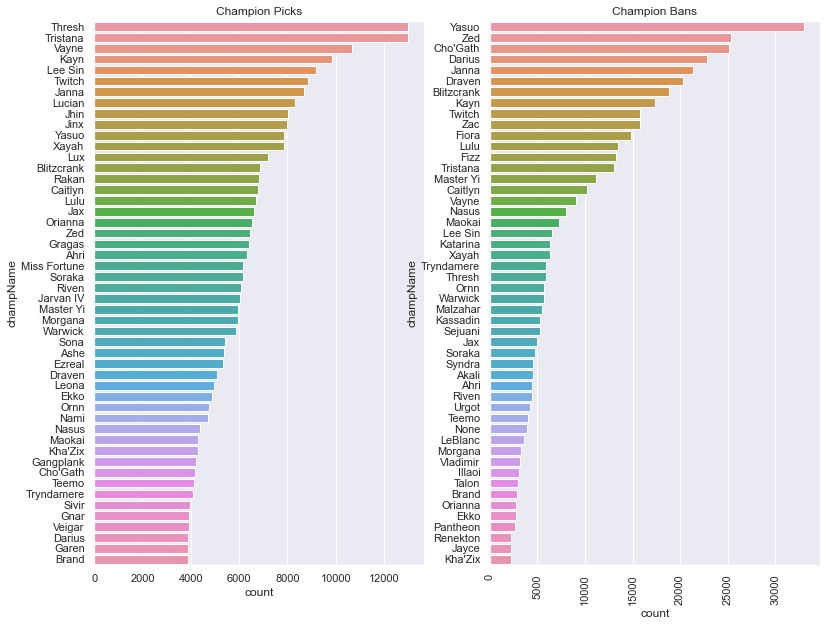

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(13,10))
plt.xticks(rotation=90)
sns.barplot(x="count", y="champName", data=champ_count.head(50), ax=ax1)
sns.barplot(x="count", y="champName", data=champ_ban_count.head(50), ax=ax2)
ax1.set_title('Champion Picks')
ax2.set_title('Champion Bans')
plt.show()

In [20]:
def extract_champs(_champ_win_df, comb_n=2):
    comb_records = [{"gameId": group_by[0],
                     "champId": comb,
                     "win": group_by[1]}
                    for group_by, group_df in _champ_win_df.groupby(["gameId", "win"])
                    for comb in combinations(sorted(group_df["champId"]), comb_n)]
    comb_df = pd.DataFrame.from_records(comb_records)
    return comb_df

bi_win_rate_df = extract_champs(champ_record_df, 2)
tri_win_rate_df = extract_champs(champ_record_df, 3)

In [21]:
def calc_champ_win_rate(_champ_win_df):
    result_df = _champ_win_df.groupby(["champId", "win"]).size().unstack(fill_value=0).reset_index()
    result_df["all-count"] = result_df[False] + result_df[True]
    result_df["win-rate"] = result_df[True] / result_df["all-count"]
    result_df.columns = ["champId", "#lose", "#win", "#all", "win-rate"]
    return result_df

single_win_rate_df = calc_champ_win_rate(champ_record_df)
binary_win_rate_df = calc_champ_win_rate(bi_win_rate_df)
triple_win_rate_df = calc_champ_win_rate(tri_win_rate_df)


In [23]:
def champ_id_to_name(champ_id, champ_info_df):

    id_map = dict(zip(champ_info_df["id"], champ_info_df["name"]))

    def _champ_str_to_name(champ_id_str):
        if re.match("\d+",champ_id_str):
            return id_map[int(champ_id_str)]
        if re.match("\((\d+, )+\d+\)", champ_id_str):
            return ", ".join([id_map[int(champ.strip())]
                              for champ in champ_id_str[1:-1].split(",")])
        raise ValueError

    if isinstance(champ_id, str):
        return _champ_str_to_name(champ_id)
    elif isinstance(champ_id, int):
        return id_map[champ_id]
    elif isinstance(champ_id, tuple):
        return ", ".join([id_map[int(champ)] for champ in champ_id])
    else:
        print(champ_id, type(champ_id))
        return pd.Series([_champ_str_to_name(item) for item in champ_id])


In [25]:
# single_win_rate_df["champName"] = single_win_rate_df["champId"].apply(lambda x: champ_id_to_name(x))
# binary_win_rate_df["champName"] = binary_win_rate_df["champId"].apply(lambda x: champ_id_to_name(x))
# triple_win_rate_df["champName"] = triple_win_rate_df["champId"].apply(lambda x: champ_id_to_name(x))


In [26]:
print(single_win_rate_df.sort_values(by=['win-rate'], ascending=False))
print(single_win_rate_df.sort_values(by=['#all'], ascending=False))
print(single_win_rate_df.sort_values(by=['#win'], ascending=False))

    champId  #lose  #win  #all  win-rate
41    Janna   3865  4826  8691  0.555287
101    Sona   2487  2942  5429  0.541905
132  Yorick    634   744  1378  0.539913
86   Rammus   1383  1614  2997  0.538539
5    Anivia   1045  1207  2252  0.535968
..      ...    ...   ...   ...       ...
83    Poppy   1034   852  1886  0.451750
48    Karma   1719  1415  3134  0.451500
9      Azir    725   555  1280  0.433594
81     Ornn   2811  1955  4766  0.410197
92     Ryze    611   421  1032  0.407946

[138 rows x 5 columns]
          champId  #lose  #win   #all  win-rate
110        Thresh   6859  6143  13002  0.472466
111      Tristana   6270  6713  12983  0.517061
119         Vayne   5160  5498  10658  0.515857
53           Kayn   5046  4807   9853  0.487872
60        Lee Sin   4971  4217   9188  0.458968
..            ...    ...   ...    ...       ...
92           Ryze    611   421   1032  0.407946
49        Karthus    493   514   1007  0.510427
8    Aurelion Sol    399   442    841  0.525565
0   

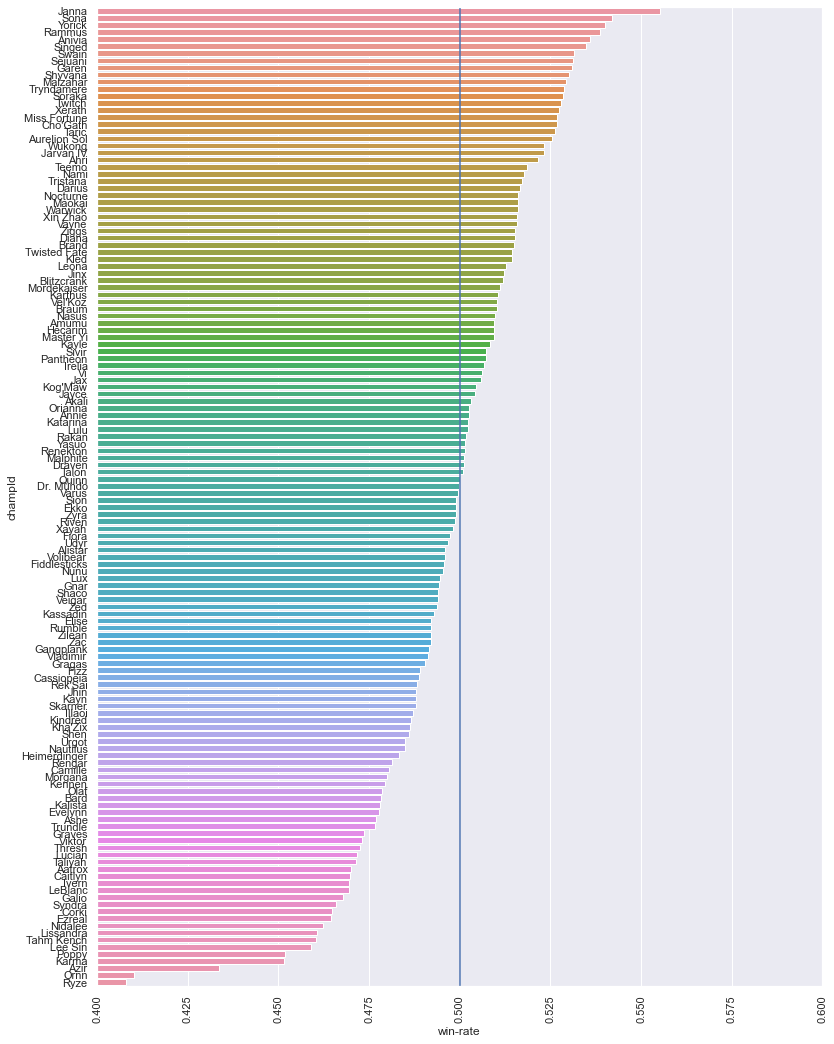

In [58]:
fig, ax1 = plt.subplots(ncols=1, sharey=False, figsize=(13,18))
plt.xticks(rotation=90)
ax1.set(xlim=(0.4, 0.6))
sns.barplot(x="win-rate", y="champId", data=single_win_rate_df.sort_values(by=['win-rate'], ascending=False), ax=ax1)
plt.axvline(0.5)

<AxesSubplot:xlabel='win-rate', ylabel='champId'>

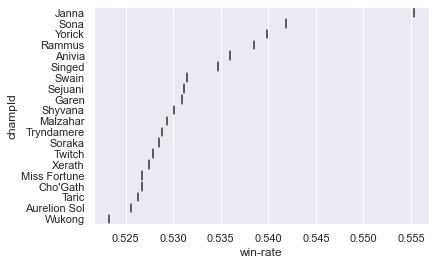

In [42]:
sns.boxplot(x="win-rate", y="champId",
            data=single_win_rate_df.sort_values(by=['win-rate'], ascending=False).head(20), color="c")

<AxesSubplot:xlabel='#all', ylabel='champId'>

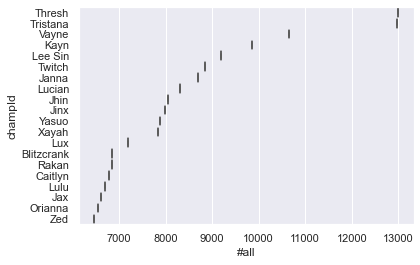

In [44]:
sns.boxplot(x="#all", y="champId",
            data=single_win_rate_df.sort_values(by=['#all'], ascending=False).head(20), color="c")

In [45]:
print(binary_win_rate_df.sort_values(by=['win-rate'], ascending=False))
print(binary_win_rate_df.sort_values(by=['#all'], ascending=False))
print(binary_win_rate_df.sort_values(by=['#win'], ascending=False))

                      champId  #lose  #win  #all  win-rate
3218       (Evelynn, Shyvana)      0     3     3       1.0
7771          (Nunu, Shyvana)      0     4     4       1.0
8868       (Skarner, Warwick)      0     2     2       1.0
6337           (Kled, Yorick)      0     1     1       1.0
1246         (Azir, Kassadin)      0     1     1       1.0
...                       ...    ...   ...   ...       ...
3237          (Evelynn, Udyr)      3     0     3       0.0
2132  (Cassiopeia, Lissandra)      4     0     4       0.0
3209       (Evelynn, Rek'Sai)      1     0     1       0.0
7450            (Nami, Rakan)      1     0     1       0.0
4384       (Hecarim, Rek'Sai)      2     0     2       0.0

[9582 rows x 5 columns]
                     champId  #lose  #win  #all  win-rate
8195          (Rakan, Xayah)   1152  1268  2420  0.523967
9177      (Thresh, Tristana)    861   712  1573  0.452638
9185         (Thresh, Vayne)    726   680  1406  0.483642
4902       (Janna, Tristana)    527

                    champId  #lose  #win  #all  win-rate
8930       (Soraka, Twitch)    246   375   621  0.603865
4910         (Janna, Vayne)    428   628  1056  0.594697
4906        (Janna, Twitch)    354   515   869  0.592635
4902      (Janna, Tristana)    527   749  1276  0.586991
4917       (Janna, Warwick)    210   297   507  0.585799
8890       (Sona, Tristana)    326   457   783  0.583653
4881         (Janna, Riven)    223   311   534  0.582397
4834           (Janna, Jax)    262   365   627  0.582137
4871       (Janna, Orianna)    246   337   583  0.578045
4922         (Janna, Yasuo)    252   340   592  0.574324
8926     (Soraka, Tristana)    363   488   851  0.573443
178           (Ahri, Janna)    231   303   534  0.567416
5333        (Jinx, Morgana)    217   284   501  0.566866
7298  (Miss Fortune, Yasuo)    221   289   510  0.566667
4833     (Janna, Jarvan IV)    243   317   560  0.566071
7484          (Nami, Vayne)    244   310   554  0.559567
252          (Ahri, Twitch)    

<AxesSubplot:xlabel='win-rate', ylabel='champId'>

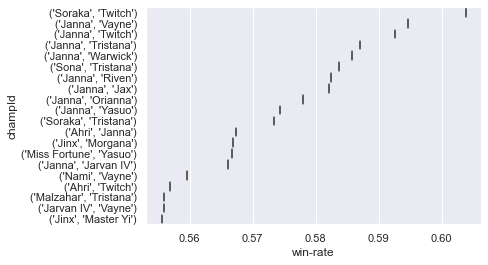

In [47]:
bi_win_rate_with_100_count_df = binary_win_rate_df[binary_win_rate_df["#all"]>500].sort_values(by=['win-rate'], ascending=False).head(20)
print(bi_win_rate_with_100_count_df)
sns.boxplot(x="win-rate", y="champId",
            data=bi_win_rate_with_100_count_df, color="c")

                     champId  #lose  #win  #all  win-rate
8195          (Rakan, Xayah)   1152  1268  2420  0.523967
9177      (Thresh, Tristana)    861   712  1573  0.452638
9185         (Thresh, Vayne)    726   680  1406  0.483642
4902       (Janna, Tristana)    527   749  1276  0.586991
5988        (Kayn, Tristana)    623   604  1227  0.492258
5987          (Kayn, Thresh)    608   598  1206  0.495854
5279          (Jhin, Thresh)    631   534  1165  0.458369
6552       (Lee Sin, Thresh)    638   521  1159  0.449525
6780        (Lucian, Thresh)    664   488  1152  0.423611
6553     (Lee Sin, Tristana)    561   577  1138  0.507030
4910          (Janna, Vayne)    428   628  1056  0.594697
9181        (Thresh, Twitch)    544   500  1044  0.478927
5371          (Jinx, Thresh)    497   544  1041  0.522574
5996           (Kayn, Vayne)    511   522  1033  0.505324
6855        (Lulu, Tristana)    507   514  1021  0.503428
9197         (Thresh, Yasuo)    517   452   969  0.466460
6561        (L

<AxesSubplot:xlabel='#all', ylabel='champId'>

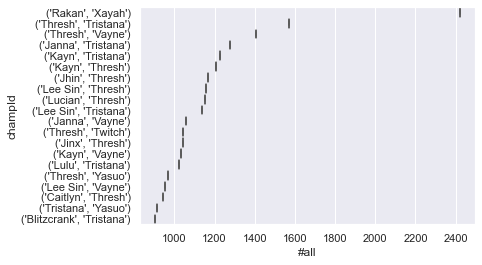

In [49]:
bi_all_with_100_count_df = binary_win_rate_df.sort_values(by=['#all'], ascending=False).head(20)
print(bi_all_with_100_count_df)
sns.boxplot(x="#all", y="champId",
            data=bi_all_with_100_count_df, color="c")

In [ ]:
#print(triple_win_rate_df.sort_values(by=['win-rate'], ascending=False))
#print(triple_win_rate_df.sort_values(by=['#all'], ascending=False))
#print(triple_win_rate_df.sort_values(by=['#win'], ascending=False))

                           champId  #lose  #win  #all  win-rate
158953        (Janna, Kayn, Vayne)     34    68   102  0.666667
158229      (Janna, Jax, Tristana)     37    70   107  0.654206
234780     (Rakan, Sejuani, Xayah)     46    83   129  0.643411
158945     (Janna, Kayn, Tristana)     44    78   122  0.639344
134344   (Gangplank, Rakan, Xayah)     44    73   117  0.623932
144178      (Gragas, Rakan, Xayah)     64   106   170  0.623529
212752         (Lux, Rakan, Xayah)     45    66   111  0.594595
167006         (Jax, Rakan, Xayah)     59    80   139  0.575540
171091        (Jhin, Kayn, Thresh)     58    78   136  0.573529
169826       (Jayce, Rakan, Xayah)     45    59   104  0.567308
83397     (Cho'Gath, Rakan, Xayah)     46    59   105  0.561905
230349     (Orianna, Rakan, Xayah)     66    83   149  0.557047
7997          (Ahri, Rakan, Xayah)     77    93   170  0.547059
235394         (Rakan, Xayah, Zed)     70    84   154  0.545455
203460     (Lee Sin, Rakan, Xayah)    10

<AxesSubplot:xlabel='win-rate', ylabel='champId'>

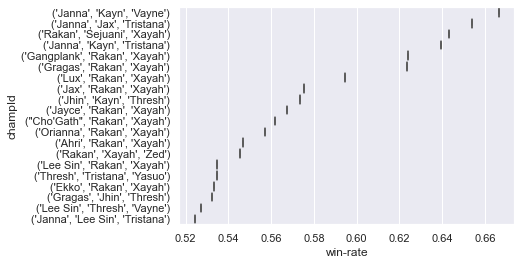

In [50]:
tri_win_rate_with_10_count_df = triple_win_rate_df[triple_win_rate_df["#all"]>100].sort_values(by=['win-rate'], ascending=False).head(20)
print(tri_win_rate_with_10_count_df)
sns.boxplot(x="win-rate", y="champId",
            data=tri_win_rate_with_10_count_df, color="c")

<AxesSubplot:xlabel='#all', ylabel='champId'>

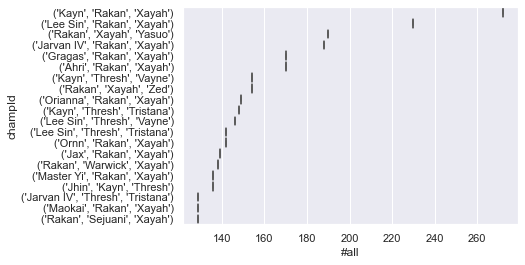

In [51]:
tri_all_with_df = triple_win_rate_df.sort_values(by=['#all'], ascending=False).head(20)
sns.boxplot(x="#all", y="champId",
            data=tri_all_with_df, color="c")

In [57]:
# champ_id_to_index_map = dict(zip(info_df.id, info_df.index.tolist()))
win_heat_arr = np.eye(len(champ_info_df))

for row_id, record in binary_win_rate_df.iterrows():
    t, w_rate = record["champId"], record["win-rate"]
    print(t)
#     t = tuple(map(lambda x: champ_id_to_index_map[x], t))
    win_heat_arr[t] = w_rate
win_heat_arr

('Aatrox', 'Aatrox')


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [56]:
win_heat_arr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
ax = sns.heatmap(win_heat_arr, center=0.5, cmap="YlGnBu", square=True)

In [ ]:
lol_df


In [59]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# one hot encoding
enc = OneHotEncoder(sparse=False)

def prepare(_lol_df, cate_cols, num_cols):
    cate_feat = pd.DataFrame(enc.fit_transform(_lol_df[cate_cols]))
    lol_feat = pd.concat([cate_feat, _lol_df[num_cols]], axis=1)
    label = _lol_df["winner"]
    # x_train, x_test, y_train, y_test
    return train_test_split(lol_feat, label)

In [60]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

x_train, x_test, y_train, y_test = prepare(lol_df, category_cols, numerical_cols)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, precision_recall_curve

confusion_result = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(confusion_result)

print(f1_score(y_true=y_test, y_pred=y_pred))
print(accuracy_score(y_true=y_test, y_pred=y_pred))
print(precision_score(y_true=y_test, y_pred=y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)

x_train, x_test, y_train, y_test = prepare(lol_df, category_cols, numerical_cols)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

In [ ]:
print(f1_score(y_true=y_test, y_pred=y_pred))
print(accuracy_score(y_true=y_test, y_pred=y_pred))
print(precision_score(y_true=y_test, y_pred=y_pred))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

labels = np.array([u" 生存 ", u" 伤害 ", u" 击败 ", u" 支援 ", u" 物资 "])
stats = [100.0, 95.0, 95.8, 62.8, 96.8]

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
stats = np.concatenate((stats, [stats[0]]))
angles = np.concatenate((angles, [angles[0]]))

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)

# 设置中文字体
font = FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf", size=14)
ax.set_thetagrids(angles * 180/np.pi, labels, FontProperties=font)
plt.show()
